# Principal Components Analysis

In this lab, we'll take a closer look at principal components analysis.

In [1]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_mldata # will be used to grab the MNIST dataset
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

PCA is one method of doing dimensionality reduction on your data. Often you'll have to deal with datasets where each
datapoint is $d$ dimensional, for some large $d$. There are many reasons to want to deal with lower dimensional data:
* cheaper computational cost of training models
* better performance (think KNN with irrelevant features removed)
* less memory overhead

## MNIST Image Dataset
[MNIST](https://en.wikipedia.org/wiki/MNIST_database) is a dataset consisting of 28x28 pixel handwritten digits that has been widely used(possibly overused) for validating various machine learning techniques. We can access this data by using sklearn's [fetch_mldata](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_mldata.html) function like so:

In [2]:
def get_mnist():
    '''
    Grabs the MNIST dataset and returns a tuple of the features and classes
    '''
    mnist = fetch_mldata('MNIST original')
    X = mnist.data.astype('float64')
    y = mnist.target
    return X, y

In [3]:
X, y = get_mnist()

In [4]:
print("Dataset shape: {}".format(X.shape))

Dataset shape: (70000, 784)


To see what these images look like, first we reshape the length $784$ vectors into 28-by-28 matrices, which we can then feed through matplotlib's [imshow](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) function.

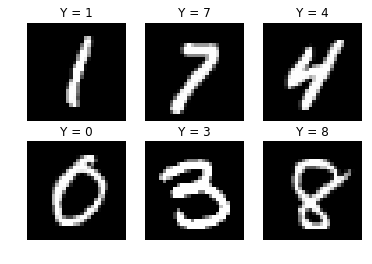

In [5]:
# Plot a few of these images at random
plt.subplots(2, 3)
for i, idx in enumerate(np.random.randint(0, len(X), 6)):
    plt.subplot(2, 3, i+1)
    plt.imshow(X[idx].reshape(28, 28), cmap='gray')
    plt.title('Y = {:d}'.format(int(y[idx])))
    plt.axis('off')

784 dimensions is maybe a bit more dimensions than we'd really like to deal with. Let's try to use PCA to map these dimensions to some lower dimensional subspace and hopefully we can get away with using less than 784 dimensions of data.

In [6]:
# Do a full PCA(aka find all 784 principal components)
pca = PCA()
pca.fit(X)
explained_var = [np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(784)]

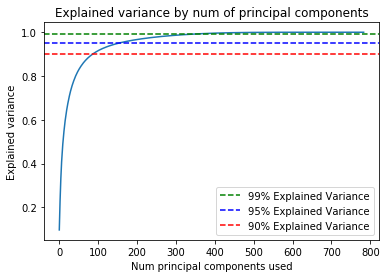

In [10]:
plt.plot(explained_var)
plt.title('Explained variance by num of principal components')
plt.xlabel('Num principal components used')
plt.ylabel('Explained variance')
plt.axhline(y=0.99, color='g', linestyle='--', label = '99% Explained Variance')
plt.axhline(y=0.95, color='b', linestyle='--', label = '95% Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--', label = '90% Explained Variance')
plt.legend()

In [11]:
for i in range(100, 800, 100):
    print("Explained var with {} components | {:.3f}".format(i, explained_var[i+1]))

Explained var with 100 components | 0.917
Explained var with 200 components | 0.967
Explained var with 300 components | 0.987
Explained var with 400 components | 0.996
Explained var with 500 components | 0.999
Explained var with 600 components | 1.000
Explained var with 700 components | 1.000


What this tells us is that we can capture most of the information in our dataset using less than half of the number of number of dimensions. In other datasets, this will be much more extreme.

Since we're dealing with an image dataset we can visually see what we lose when we map our data down to lower dimensions. Let's first map the data down to 100 dimensions with PCA. We can map the 100 dimensional data back to length 784 dimension vectors using [PCA.inverse_transform](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.inverse_transform) and then turn this into a 28-by-28 image.

In [12]:
pca = PCA(n_components=100)
X_100 = pca.fit_transform(X)
print("Dimensionally reduced data shape: {}".format(X_100.shape))
X_reconstructed = pca.inverse_transform(X_100)
print("Reconstructed image shape: {}".format(X_reconstructed.shape)) # should be back to 784 dims

Dimensionally reduced data shape: (70000, 100)
Reconstructed image shape: (70000, 784)


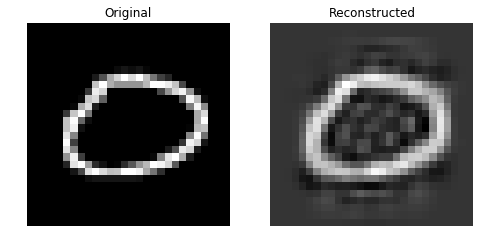

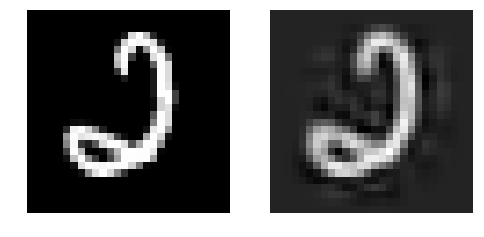

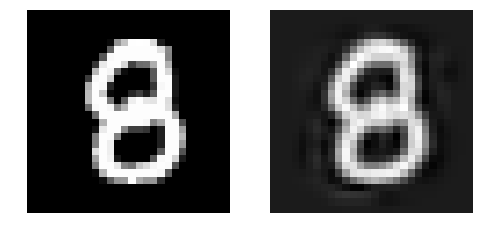

In [13]:
# pick a few points. Show original and reconstructed(with 200 principal components) images
for i, idx in enumerate(np.random.randint(0, len(X), 3)):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(X[idx].reshape(28, 28), cmap='gray')
    if i == 0:
        plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(X_reconstructed[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Reconstructed")
    plt.show()

### Task #1
1) Do PCA using 10, 25, and 50 components. Plot a few images of the reconstructed images(using inverse_transform like we did above) for each. Are the digits still recognizeable?

## Fitting a model to the dimensionally reduced data
We can eyeball these reconstructed images that use less than 784 features. The results are a bit blurrier than the original image, but we can still generally what the images are. This is all well and good, but now you should ask, can we train a model on top of the dimensionally reduced datapoints? How much of a performance hit will we see if we train a model on top of the 200-dimensional data versus the full 784 dimensional data?

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
train_indices, test_indices = train_test_split(range(len(X)), test_size=0.2, shuffle=True)

We'll train a Logistic Regression model. On top of the 100-dim data, and the 784 dimensional data and compare precision scores. For the LogisticRegression, set the solver to 'sag'(Stochastic average gradient). It's not too important what this does, but the default solver is too slow for the size of our dataset.

In [15]:
# recall that X_100 is the data lives in the 100 dimensional subspace spanned by the first 100 principal components
lr = LogisticRegression(solver='sag', n_jobs=-1, multi_class='multinomial')
lr.fit(X_100[train_indices], y[train_indices])
y_pred_100 = lr.predict(X_100[test_indices])
prec_100 = precision_score(y_pred_100, y[test_indices], average='macro')
print("Precision score with {} dimensional input: {:.3f}".format(X_100.shape[1], prec_100))

Precision score with 100 dimensional input: 0.908


In [16]:
# Note this might take a few minutes b/c the optimization problem is more expensive with more dimensions!
lr = LogisticRegression(solver='sag', n_jobs=-1, multi_class='multinomial')
lr.fit(X[train_indices], y[train_indices])
y_pred = lr.predict(X[test_indices])
prec_full = precision_score(y_pred, y[test_indices], average='macro')
print("Precision score with {} dimensional input: {:.3f}".format(X.shape[1], prec_full))
# this maybe doesnt converge but that's okay

Precision score with 784 dimensional input: 0.916


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


So it looks like we really don't suffer too much from using the first 100 principal components!

# Task #2
These two code blocks for fitting a logistic regression model to the 100-dimensional data and the full 784-dimensional data are pretty similar. Write a function performs PCA to map the data down to a $d$ dimensional space, and then fit+evaluate a logistic regression model to it. 

In [ ]:
def train_reduced_dim_model(X, y, dim, eval_metric):
    pca = PCA(n_components=dim)
    X_100 = pca.fit_transform(X)
    print("Dimensionally reduced data shape: {}".format(X_100.shape))
    X_reconstructed = pca.inverse_transform(X_100)
    print("Reconstructed image shape: {}".format(X_reconstructed.shape)) # should be back to 784 dims
    pass

## Final Comments
Generally you want to use PCA if
* you want to reduce the dimensionality of your dataset to something more feasible
* you want independent features
* you don't care about interpretability

The last point is important. For the MNIST dataset, every feature was a single pixel of the image. There is not too much meaning we're losing by using PCA. The principal components are then just some kind of linear combination of a bunch of pixel values. However, when dealing with some kind of policy data, our features _do_ have important interpretations that we probably don't want to lose. This is all to say that PCA can be a useful tool, but you should be wary of how, and when you do use it.

## Extra:
You can also pass in a float value between $0$ and $1$ to PCA. This will then instead compute the number of components needed to get that amount of the explained variance. For example:

In [150]:
for explained_var in [0.8, 0.85, 0.95, 0.99, 0.999]:
    pca_ = PCA(n_components=explained_var)
    pca_.fit(X)
    print("Num components needed to capture {:.3f} of variance: {}".format(explained_var, pca_.n_components_))

Num components needed to capture 0.800 of variance: 43
Num components needed to capture 0.850 of variance: 59
Num components needed to capture 0.950 of variance: 154
Num components needed to capture 0.990 of variance: 331
Num components needed to capture 0.999 of variance: 486


Try using PCA on your data for your project or for the data from assignment 3 to capture 90% of the variance of the data. How many dimensions did you need?